# Error Analysis
In this notebook, our objective is to analyze the errors made by our top networks. Specifically, we aim to discern whether these errors are consistent across the networks or if the networks exhibit distinct predictive capabilities.

## Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import numpy as np
import pandas as pd
from tensorflow import keras
import math
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from tensorflow.keras.preprocessing import image
from keras.models import Model
import pdb
import matplotlib.cm as cm

# Connection to Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/Utils.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will also handle the downloading and extraction of the dataset from the Google Drive folder.

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-split.zip" -d '/'

# Dataset loading
Next, we will create Dataset objects from the data stored in the sets directory, utilizing the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function provided by Keras.

In [ ]:
train_ds, val_ds, test_ds = load_data_splits(IMAGE_SIZE, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


Here are the counts of images for each of the two classes, "hem" and "all," in the test set.

In [ ]:
num_all_test = len(os.listdir(PREPROCESSED_DIR + "/test_set/all"))
num_hem_test = len(os.listdir(PREPROCESSED_DIR + "/test_set/hem"))

total_test = num_all_test + num_hem_test

In [ ]:
print('total test all cell images:', num_all_test)
print('total test hem cell images:', num_hem_test)
print("--")
print("Total test images:", total_test)

total test all cell images: 1463
total test hem cell images: 670
--
Total test images: 2133


# Model Loading
We have loaded the best model for each type of network trained, which includes the CNN from scratch, VGG16, and ResNet. These models were selected based on their accuracy on the test set, serving as the evaluation criterion.

In [ ]:
from_scratch_model = models.load_model(MODELS_PATH + '/Dense512Neurons_OneDropout0-3/Dense512Neurons_OneDropout0-3.h5')
vgg_model = models.load_model(MODELS_PATH + '/VGG16_LastBlockFineTuned/VGG16_LastBlockFineTuned.h5')
resnet_model = models.load_model(MODELS_PATH + '/ResNet50_Finetuned/ResNet50_Finetuned.h5')

### Errors of the models on the test set
Initially, we extract both the true labels and the predicted labels for the test set.

In [ ]:
true_labels = tf.concat([labels_batch for data_batch, labels_batch in test_ds], axis = 0)
from_scratch_labels = np.rint(from_scratch_model.predict(test_ds))
vgg_labels = np.rint(vgg_model.predict(test_ds))
resnet_labels = np.rint(resnet_model.predict(test_ds))

34/34 [==============================] - 10s 215ms/step


Here's a bar graph that illustrates, on the x-axis, the images within the test set and, on the y-axis, the count of classifiers that misclassify each respective image.

In [ ]:
labels = []
for i in range(len(true_labels)):
  labels.append([int(true_labels[i]), int(from_scratch_labels[i]), int(vgg_labels[i]), int(resnet_labels[i])])

In [ ]:
misclassifications = [len(label) - label.count(label[0]) for label in labels]

Misclassified images from all 3 classifiers:  48
Misclassified images from 2 classifiers:  135
Misclassified images from 1 classifiers:  274


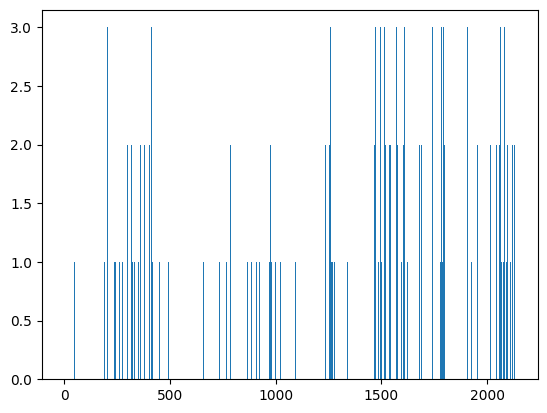

In [ ]:
print("Misclassified images from all 3 classifiers: ", len([1 for misclassification in misclassifications if misclassification == 3]))
print("Misclassified images from 2 classifiers: ", len([1 for misclassification in misclassifications if misclassification == 2]))
print("Misclassified images from 1 classifiers: ", len([1 for misclassification in misclassifications if misclassification == 1]))
plt.bar(range(len(labels)),misclassifications)
plt.show()

In [ ]:
misclassifications_classifier = []
for i in range(len(labels)):
  if labels[i].count(labels[i][0]) == len(labels[i]): # if all classifiers are good ad recognizing the image
    misclassifications_classifier.append([])
    continue
  wrong_classifiers = [index for index, predicted_class in enumerate(labels[i]) if predicted_class != labels[i][0]]
  misclassifications_classifier.append(wrong_classifiers)

In [ ]:
print("Images that are misclassified by all classifiers: ", len([1 for misclassification in misclassifications_classifier if len(misclassification) == 3]))
print("\n")
print("Images that are misclassified only by CNN from scratch: ", len([1 for misclassification in misclassifications_classifier
                                                                 if len(misclassification) == 1 and 1 in misclassification]))
print("Images that are correctly classified only by CNN from scratch: ", len([1 for misclassification in misclassifications_classifier
                                                                 if len(misclassification) == 2 and 1 not in misclassification]))
print("\n")
print("Images that are misclassified only by VGG: ", len([1 for misclassification in misclassifications_classifier
                                                                 if len(misclassification) == 1 and 2 in misclassification]))
print("Images that are correctly classified only by VGG: ", len([1 for misclassification in misclassifications_classifier
                                                                 if len(misclassification) == 2 and 2 not in misclassification]))
print("\n")
print("Images that are misclassified only by ResNet50: ", len([1 for misclassification in misclassifications_classifier
                                                                 if len(misclassification) == 1 and 3 in misclassification]))
print("Images that are correctly classified only by ResNet50: ", len([1 for misclassification in misclassifications_classifier
                                                                 if len(misclassification) == 2 and 3 not in misclassification]))

Images that are misclassified by all classifiers:  48


Images that are misclassified only by CNN from scratch:  74
Images that are correctly classified only by CNN from scratch:  86


Images that are misclassified only by VGG:  82
Images that are correctly classified only by VGG:  27


Images that are misclassified only by ResNet50:  118
Images that are correctly classified only by ResNet50:  22


In [ ]:
images =  tf.concat([data_batch for data_batch, labels_batch in test_ds], axis = 0)

#### Misclassified images from all models

In [ ]:
def plot_images(images, indexes):
  n = len(indexes)
  rows = math.ceil(n/6)
  columns = 6
  fig = plt.figure(figsize=(columns*3,rows*3))
  for i in range(1, n+1):
    img = np.squeeze(images[indexes[i-1]]/255)
    fig.add_subplot(rows, columns, i)
    title = "Image " + str(indexes[i-1]) + ", class: "
    if indexes[i-1] < 1463:
      title = title + "all"
    else:
      title = title + "hem"
    plt.title(title)
    plt.imshow(img)

  fig.tight_layout()
  plt.show()

In [ ]:
total_misclassification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 3]

In [ ]:
plot_images(images, total_misclassification_indexes)

Output hidden; open in https://colab.research.google.com to view.

### CNN from scratch

#### Misclassified images from CNN from scratch

In [ ]:
scratch_misclassification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 1 and 1 in misclassifications_classifier[i]]

In [ ]:
plot_images(images, scratch_misclassification_indexes)

Output hidden; open in https://colab.research.google.com to view.

#### Images correctly classified only from CNN

In [ ]:
scratch_classification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 2 and 1 not in misclassifications_classifier[i]]

In [ ]:
plot_images(images, scratch_classification_indexes)

Output hidden; open in https://colab.research.google.com to view.

### VGG

#### Misclassified images from VGG

In [ ]:
vgg_misclassification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 1 and 2 in misclassifications_classifier[i]]

In [ ]:
plot_images(images, vgg_misclassification_indexes)

Output hidden; open in https://colab.research.google.com to view.

#### Images correctly classified only from VGG

In [ ]:
vgg_classification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 2 and 2 not in misclassifications_classifier[i]]

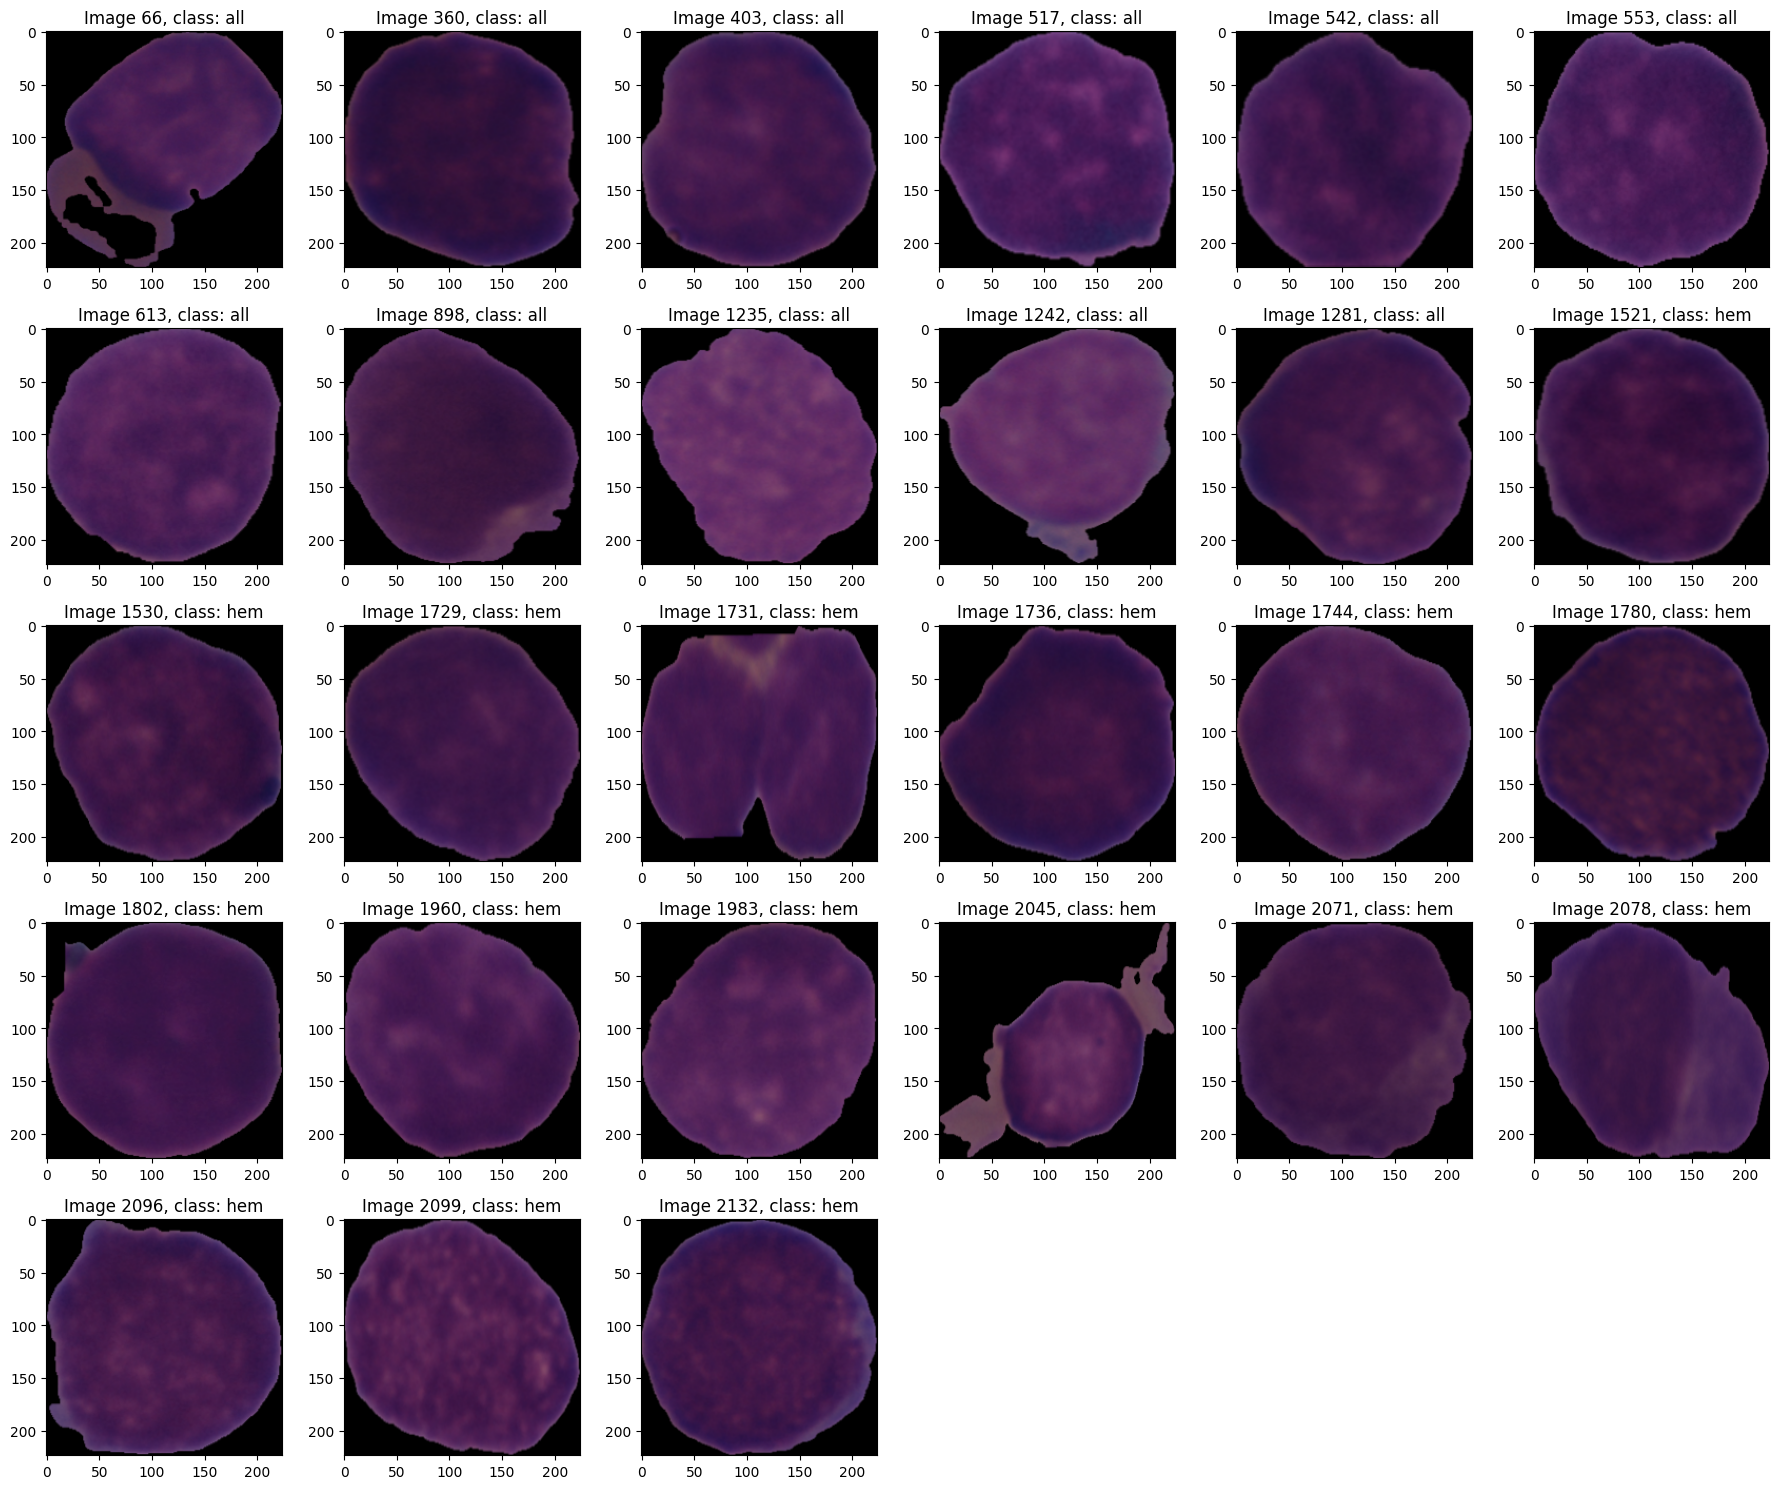

In [ ]:
plot_images(images, vgg_classification_indexes)

### ResNet50

#### Misclassified images from ResNet50

In [ ]:
resnet_misclassification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 1 and 3 in misclassifications_classifier[i]]

In [ ]:
plot_images(images, resnet_misclassification_indexes)

Output hidden; open in https://colab.research.google.com to view.

#### Images correctly classified only from ResNet50

In [ ]:
resnet_classification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 2 and 3 not in misclassifications_classifier[i]]

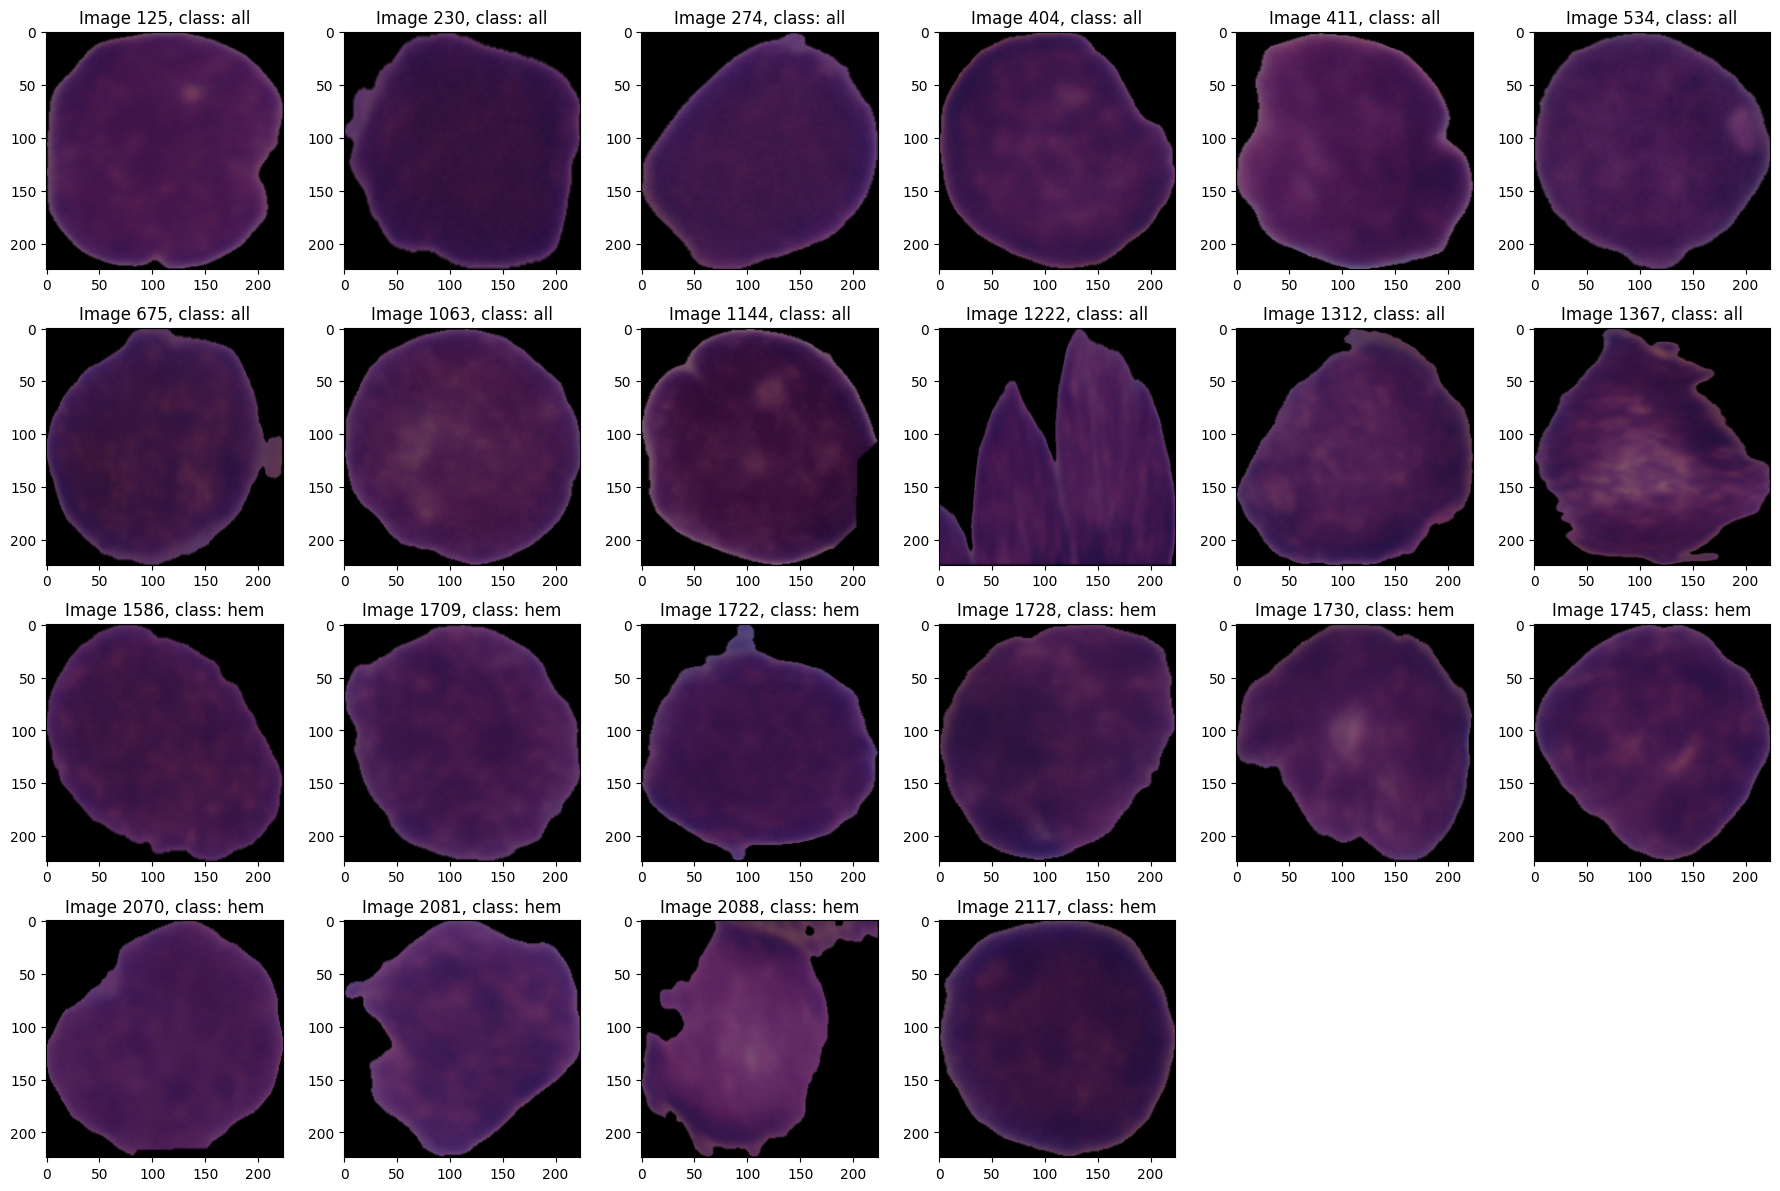

In [ ]:
plot_images(images, resnet_classification_indexes)